In [18]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from torch import optim
import torch.nn.functional as F
import random
import cv2
from skimage import morphology

In [19]:
#uncomment this to mount a drive on google colab
#from google.colab import drive
#drive.mount('/content/drive')

# CNN with preprocessing and postprocessing

## Global variables

In [20]:
# Variables

root_dir = ""

load_model = True

patch_size = 16
train_size = 400
test_size = 608

lr = 1e-4
nb_epoch = 100
batch_size = 1
criterion = nn.BCEWithLogitsLoss()

model_name = "convmodel" + str(nb_epoch) + ".pth"

#boolean to choose if we use preprocessing or not
prepro = False
#boolean to choose between gaussian blur or pixel removal for preprocessing
gaussian = True

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu") 

## Preprocessing

In [21]:
#turns a color image into grayscale
def rgb2gray(rgb):
    return np.dot(rgb, [0.2989, 0.5870, 0.1140])

# Threshold of max difference between two of the three RGB colors
limit = 0.05
# Method that converts all pixels not in the grayscale into black
def removeUselessPixels(img):
  # Get the RGB values
  tab1 = img[:,:,0]
  tab2 = img[:,:,1]
  tab3 = img[:,:,2]

  # Compute the difference between RG, RB, GB
  sub1 = np.absolute(tab1-tab2)
  sub2 = np.absolute(tab1-tab3)
  sub3 = np.absolute(tab2-tab3)


  # Set to one values under the threshold, zero otherwise
  sub1[sub1 > limit] = 0
  sub1[sub1 != 0] = 1
  sub2[sub2 > limit] = 0
  sub2[sub2 != 0] = 1
  sub3[sub3 > limit] = 0
  sub3[sub3 != 0] = 1

  # Multiply them to do a logical AND, 1 are gray pixels, 0 are not
  sub = sub1*sub2*sub3


  # Multiply the result to the three channels so that we keep only the useful values
  img[:,:,0] = img[:,:,0]*sub
  img[:,:,1] = img[:,:,1]*sub
  img[:,:,2] = img[:,:,2]*sub

  return img


In [22]:
# Datasaet for training data
class RSDataset(Dataset):
    def __init__(self, root_dir):
        self.image_dir = root_dir + "images/"
        self.gt_dir = root_dir + "groundtruth/"
        self.root_dir = root_dir
        self.imgs = os.listdir(self.image_dir)
        self.gt = os.listdir(self.gt_dir)
        self.gt.sort()
        self.imgs.sort()
        self.size = len(self.imgs)
    
    def __len__(self):
        return self.size

    def __getitem__(self,index):

        # Image processing

        if prepro :
          if gaussian :
            img = cv2.GaussianBlur( mpimg.imread(self.image_dir + self.imgs[index]).astype(np.float32),(5,5),cv2.BORDER_DEFAULT)
          else:
            img = cv2.bilateralFilter(removeUselessPixels(mpimg.imread(self.image_dir + self.imgs[index])),8,10,16)
        else:
          img = mpimg.imread(self.image_dir + self.imgs[index])
        img_full = torch.tensor(img).permute(2,0,1)
        img = img_crop(img, 16,16)
        img = torch.tensor(img).permute(0,3,1,2)
        img = img.to(device)

        # Mask processing
        gt_img = mpimg.imread(self.gt_dir + self.gt[index])
        gt_full = torch.tensor(gt_img)
        gt_img = img_crop(gt_img, patch_size, patch_size)
        gt_img = torch.tensor(gt_img)
        gt_img = gt_img.view(625,-1).mean(dim=1)
        gt_img[gt_img < 0.5] = 0
        gt_img[gt_img > 0.5] = 1
        gt_img = gt_img.to(device)

        return {
            'image': img,
            'target': gt_img,
            'image_full':img_full,
            'target_full': gt_full
        }

## Dataset for training data, and data loader

## Test Dataset



In [23]:
# Dataset for the test images
class RSTestDataset(Dataset):
    def __init__(self, root_dir):
        self.image_dir = root_dir + "test_set_images/"
        self.root_dir = root_dir
        self.imgs = os.listdir(self.image_dir)
        self.imgs.sort()
        self.size = len(self.imgs)
    
    def __len__(self):
        return self.size

    def __getitem__(self,index):
        filename = "test_{0}/test_{0}.png".format(index+1)

        # Image processing
        if prepro :
          if gaussian :
            img = cv2.GaussianBlur(mpimg.imread(self.image_dir + filename).astype(np.float32),(5,5),cv2.BORDER_DEFAULT)
          else:
            img = cv2.bilateralFilter(removeUselessPixels(mpimg.imread(self.image_dir + filename)),8,10,16)
        else:
          img = mpimg.imread(self.image_dir + filename)
        img_full = torch.tensor(img).permute(2,0,1)
        img = img_crop(img, patch_size, patch_size)
        img = torch.tensor(img)
        img = img.permute(0,3,1,2)
        img = img.to(device)
        

        return {
            'image': img,
            'image_full': img_full,
            'filename' : "test_{0}.png".format(index+1)
        }

## Load datasets

In [24]:
# Load a set of images
datasetTrain = RSDataset(root_dir)
datasetTest = RSTestDataset(root_dir)

# Split into training and validation dataset
n_train = int(len(datasetTrain) * 0.9)
n_val = len(datasetTrain) - n_train
train, val = random_split(datasetTrain, [n_train, n_val])
train_loader = DataLoader(train, batch_size=1, shuffle=True)
val_loader = DataLoader(val, batch_size=1, shuffle=True)

## Utils

In [25]:
# Utils taken from class
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

## Model definition and training

In [26]:
# Convolutional Network for our model
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3,32,2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32,64,4)
    self.conv3 = nn.Conv2d(64,128,2)

    self.fc1 = nn.Linear(128, 512)
    self.fc2 = nn.Linear(512, 1)
    self.relu = nn.ReLU()

  def forward(self,x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.relu(x)
    
    x = self.conv2(x)
    x = self.pool(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.relu(x)


    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.relu(x)

    x = self.fc2(x)

    return x

In [27]:
# Train a model, given a loss function (criterion), an optimizer, an epoch number, a training_loader and a validation_loader
def trainModel(model, criterion, optimizer, epoch, train_loader, val_loader): 
    model = model.to(device)
    print("TRAINING")
    print("EPOCH : TRA_LOSS : VAL_LOSS")
    try:
      for e in range(epoch):

          sum_loss = 0
          #training
          for batch in train_loader:
              optimizer.zero_grad()
              prediction = model(batch["image"].squeeze(0))
              loss = criterion(prediction.squeeze(1), batch["target"].squeeze(0))
              nn.utils.clip_grad_value_(model.parameters(), 0.1)
              loss.backward()
              optimizer.step()
              sum_loss += loss.item() / len(train_loader)

          #validation
          loss_valid = 0
          for batch in val_loader:
            with torch.no_grad():
              prediction = model(batch["image"].squeeze(0))
              loss = criterion(prediction.squeeze(1), batch["target"].squeeze(0))
              loss_valid += loss.item() / len(val_loader)
          print("{:5} {:>10.4f} {:>10.4f}".format(e, sum_loss, loss_valid))

    except KeyboardInterrupt:
      print("Interrupted at epoch " + str(e))
      torch.save(model.state_dict, "ckptConv.PTH")

In [28]:
# Loads the model or compute and save it
model = ConvNet().to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr, weight_decay=1e-8)
 
if not load_model :
  trainModel(model,criterion, optimizer, nb_epoch, train_loader, val_loader)
  torch.save(model.state_dict, root_dir + model_name)
else :
  model.load_state_dict(torch.load(root_dir + model_name, map_location=device)())

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)


## Postprocessing

In [29]:
# Transforms patches in an image in single pixels
def imagePatchToPixels(image, patchSize):
  imgSize = image.shape[0]
  assert imgSize % patchSize == 0
  assert imgSize == image.shape[1]

  size = int(imgSize / patchSize)
  pixelated = np.zeros([size, size])

  steps = range(0, imgSize, patchSize)
  for indI, i in enumerate(steps):
    for indJ, j in enumerate(steps):
      pixelated[indI][indJ] = image[i][j]

  return pixelated

In [30]:
# Transforms a pixelated image to one with patches of the given size 
def pixelsToImagePatch(image, patchSize):
  imgSize = image.shape[0]
  assert imgSize == image.shape[1]

  size = int(imgSize * patchSize)
  pixelated = np.zeros([size, size])

  steps = range(size)
  for i in steps:
    for j in steps:
      pixelated[i][j] = image[int(i/patchSize)][int(j/patchSize)]

  return pixelated

In [31]:
# Does the postprocessing of the prediction
def postProcessing(prediction):
  size = len(prediction)

  start = imagePatchToPixels(prediction, patch_size)

  closed = morphology.binary_closing(start, selem=morphology.square(2))
  opened_vert = morphology.opening(closed, selem=morphology.rectangle(5,1))
  opened_hor = morphology.opening(closed, selem=morphology.rectangle(1,5))
  reclosed_vert = morphology.closing(opened_vert, selem=morphology.rectangle(5,1))
  reclosed_hor = morphology.closing(opened_hor, selem=morphology.rectangle(1,5))
  
  shape = (int(size/patch_size), int(size/patch_size))
  result = np.zeros(shape)
  result = np.asarray([l or reclosed_vert.reshape(shape[0]*shape[1]).astype(int)[i] for i,l in enumerate(reclosed_hor.reshape(shape[0]*shape[1]).astype(int))]).reshape(shape)

  return pixelsToImagePatch(result, patch_size)

## Prediction creation

In [32]:
# Create masks with the test images. Results in a result folder
def computePrediction(model, dataset, imageSize, threshold=0.3, postprocessing=True):
  rand = random.randint(0, len(dataset)-1)

  for i in range(len(dataset)):
      sample = dataset[i]
      with torch.no_grad():
        prediction = model(sample["image"])

      size = int(np.sqrt(imageSize))
      nb_patchs = int(size / patch_size)

      prediction = torch.sigmoid(prediction).squeeze(1).to(torch.device("cpu"))
      prediction[prediction > threshold] = 1
      prediction[prediction < threshold] = 0
      prediction= F.interpolate(prediction.view(1,1,nb_patchs,nb_patchs).float(), size=(size, size)).squeeze(0).squeeze(0).T
      prediction = prediction.detach().numpy()

      if postprocessing:
        prediction = postProcessing(prediction)

      if dataset==datasetTest:
        input = sample["image_full"].to(torch.device("cpu")).permute(1,2,0).numpy()
        cimg = concatenate_images(input, prediction)

        if not os.path.exists(root_dir + "results/"):
          os.makedirs(root_dir + "results/")
        mpimg.imsave(root_dir + "results/" + "result_" + sample['filename'][5:], prediction, cmap='Greys_r')

      elif dataset==datasetTrain:
        input = sample["image_full"].to(torch.device("cpu")).permute(1,2,0).numpy()
        target = sample["target_full"].to(torch.device("cpu")).numpy()
        cimg = concatenate_images(input, prediction)
        cimg = concatenate_images(cimg,target)

        if not os.path.exists(root_dir + "results_train/"):
          os.makedirs(root_dir + "results_train/")
        mpimg.imsave(root_dir + "results_train/" + "resultTrain_" + '%.3d' % i + '.png', cimg, cmap='Greys_r')

      #display a random sample to appreciate the quality
      if i == rand:
          fig = plt.figure(figsize=(10, 10))
          plt.title("Image " + str(i) + " / " + str(len(dataset)))
          plt.imshow(cimg, cmap='Greys_r')
          plt.axis("off")

      print("\rPrediction " + str(i+1) + " / " + str(len(dataset)), end='', flush=True)

Prediction 100 / 100

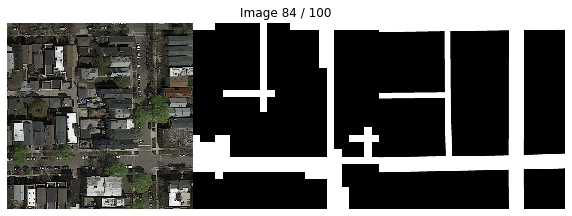

In [33]:
computePrediction(model, datasetTrain, train_size**2)

Prediction 50 / 50

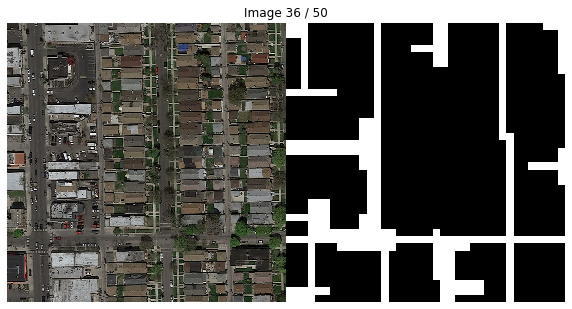

In [34]:
computePrediction(model, datasetTest, test_size**2)